## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import math

from tqdm import tqdm
from pathlib import Path
from pandas.api.types import CategoricalDtype
from ydata_profiling import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

### Constants

In [107]:
# 1 Preliminaries

RANDOM_STATE = 42

MARKETING_PATH =  Path('../data/raw/customer_shopping_data.csv')
REPORTS_DIR = Path('../reports/')
DATA_PART = 0.2

FEATURES_TO_DEL = ['invoice_no', 'customer_id']

FEATURE_OUTLIER_THRESHOLDS = {
    'price': {'upper': 4000},
}

FEATURES_CAT = ['gender', 'category', 'payment_method', 'shopping_mall']
FEATURES_DATE = ['invoice_date']

FEATURE_ORD_LEVELS = {
    'quantity': ['1', '2', '3', '4', '5'],
}

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = 'category_quantity_mall_spent'
MI_SCORES_THRESHOLD = 0

## 3 Feature Engineering

FEATURES_NEW_TO_DEL = ['invoice_date', 'age']

FEATURE_NEW_ORD_LEVELS = {
    'quantity': ['1', '2', '3', '4', '5'],
    'age_group': ['Juvenile', 'Youth', 'Average', 'Elderly'],
}

PCA_N_COMPONENTS = 20

## 4 Clustering

N_CLUSTERS = 6

FEATURES_NUM_INTERESTING = ['price', 'prop_counts', 'prop_spent']
FEATURES_CAT_INTERESTING = ['category', 'quantity', 'shopping_mall', 'age_group', 'season']

### Configs

In [3]:
warnings.filterwarnings('ignore')

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

REPORTS_DIR.mkdir(exist_ok=True)

## 1.2 Data Preprocessing

### Read

In [4]:
def read_data(path, data_part=1.0):
    df = pd.read_csv(path)
    return df.sample(int(len(df) * data_part)).reset_index(drop=True)

In [5]:
df = read_data(MARKETING_PATH, DATA_PART)
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I704758,C971218,Female,56,Food & Beverage,4,20.92,Cash,14/05/2021,Kanyon
1,I218404,C949846,Male,22,Food & Beverage,5,26.15,Cash,9/9/2022,Metrocity
2,I195516,C440398,Female,53,Food & Beverage,4,20.92,Debit Card,1/4/2021,Kanyon
3,I833735,C113971,Female,65,Food & Beverage,5,26.15,Credit Card,3/8/2022,Cevahir AVM
4,I144592,C529879,Female,51,Shoes,4,2400.68,Credit Card,15/04/2021,Metropol AVM


### Clean

In [6]:
def clean(df, features_to_del):
    df = df.drop(columns=features_to_del)
    df['category_quantity_mall_counts'] = df.groupby(['category', 'quantity', 'shopping_mall'])['price'].transform('count')
    df['category_quantity_mall_spent'] = df.groupby(['category', 'quantity', 'shopping_mall'])['price'].transform('sum')
    return df

In [7]:
df = clean(df, FEATURES_TO_DEL) 
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,56,Food & Beverage,4,20.92,Cash,14/05/2021,Kanyon,113,2363.96
1,Male,22,Food & Beverage,5,26.15,Cash,9/9/2022,Metrocity,93,2431.95
2,Female,53,Food & Beverage,4,20.92,Debit Card,1/4/2021,Kanyon,113,2363.96
3,Female,65,Food & Beverage,5,26.15,Credit Card,3/8/2022,Cevahir AVM,30,784.50
4,Female,51,Shoes,4,2400.68,Credit Card,15/04/2021,Metropol AVM,28,67219.04


### Missing Values

In [8]:
df.isna().sum().sum()

0

### Outliers

In [9]:
def get_outlier_indexes(df, feature_outlier_thresholds):
    outlier_indexes = set()
    
    for feature, thresholds in feature_outlier_thresholds.items():
        if 'upper' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] > thresholds['upper']].index))
        elif 'lower' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] < thresholds['lower']].index))

    return list(outlier_indexes)

In [10]:
def drop_outliers(df, outlier_indexes):
    return df.drop(index=outlier_indexes)

In [11]:
outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
len(outlier_indexes)

413

In [12]:
df_without_outliers = drop_outliers(df, outlier_indexes)
df_without_outliers.shape

(19478, 10)

### Encode

In [13]:
def encode(df, features_cat, features_date, feature_ord_levels, format='%d-%m-%Y'):
    
    def encode_cat(df, features_cat):
        for feature in features_cat:
            df[feature] = df[feature].astype('category')
        return df

    def encode_date(df, features_date):
        for feature in features_date:
            df[feature] = pd.to_datetime(df[feature], format=format)
        return df

    def encode_ord(df, feature_ord_levels):
        for feature, levels in feature_ord_levels.items():
            df[feature] = df[feature].astype('str').astype(CategoricalDtype(levels, ordered=True))
        return df
    
    df = encode_cat(df, features_cat)
    df = encode_date(df, features_date)
    df = encode_ord(df, feature_ord_levels)
    return df

In [14]:
df = encode(df, FEATURES_CAT,  FEATURES_DATE, FEATURE_ORD_LEVELS, format='%d/%m/%Y')
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,56,Food & Beverage,4,20.92,Cash,2021-05-14,Kanyon,113,2363.96
1,Male,22,Food & Beverage,5,26.15,Cash,2022-09-09,Metrocity,93,2431.95
2,Female,53,Food & Beverage,4,20.92,Debit Card,2021-04-01,Kanyon,113,2363.96
3,Female,65,Food & Beverage,5,26.15,Credit Card,2022-08-03,Cevahir AVM,30,784.50
4,Female,51,Shoes,4,2400.68,Credit Card,2021-04-15,Metropol AVM,28,67219.04


In [15]:
df.dtypes

gender                                 category
age                                       int64
category                               category
quantity                               category
price                                   float64
payment_method                         category
invoice_date                     datetime64[ns]
shopping_mall                          category
category_quantity_mall_counts             int64
category_quantity_mall_spent            float64
dtype: object

### Summary

In [16]:
def load_data(path, data_part, features_to_del, features_cat, features_date, feature_ord_levels):
    df = read_data(path, data_part)
    df = clean(df, features_to_del)
    #df = impute(df)

    outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
    df = drop_outliers(df, outlier_indexes)
    
    df = encode(df, features_cat, features_date, feature_ord_levels, format='%d/%m/%Y')
    return df

In [17]:
df = load_data(MARKETING_PATH, DATA_PART, FEATURES_TO_DEL, FEATURES_CAT, FEATURES_DATE, FEATURE_ORD_LEVELS)
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,category_quantity_mall_counts,category_quantity_mall_spent
0,Female,56,Shoes,5,3000.85,Credit Card,2022-03-01,Metrocity,57,171048.45
1,Male,57,Clothing,4,1200.32,Cash,2022-03-01,Zorlu Center,79,94825.28
2,Male,47,Souvenir,3,35.19,Credit Card,2022-09-23,Istinye Park,19,668.61
3,Male,56,Food & Beverage,4,20.92,Credit Card,2021-10-19,Zorlu Center,32,669.44
4,Male,29,Cosmetics,3,121.98,Cash,2021-07-25,Forum Istanbul,22,2683.56


In [18]:
df.isna().sum().sum()

0

In [19]:
df.dtypes

gender                                 category
age                                       int64
category                               category
quantity                               category
price                                   float64
payment_method                         category
invoice_date                     datetime64[ns]
shopping_mall                          category
category_quantity_mall_counts             int64
category_quantity_mall_spent            float64
dtype: object

## 2 Feature Utility Scores

## 2.1 MI Scores

In [22]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [23]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

In [24]:
X_mi = df.copy()
y_mi = X_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

mi_scores = make_mi_scores(X_mi, y_mi, random_state=RANDOM_STATE)
mi_scores

category_quantity_mall_counts    4.552317
price                            3.345940
shopping_mall                    1.998951
category                         1.819602
quantity                         1.536964
gender                           0.006361
age                              0.001044
payment_method                   0.000000
invoice_date                     0.000000
Name: MI Scores, dtype: float64

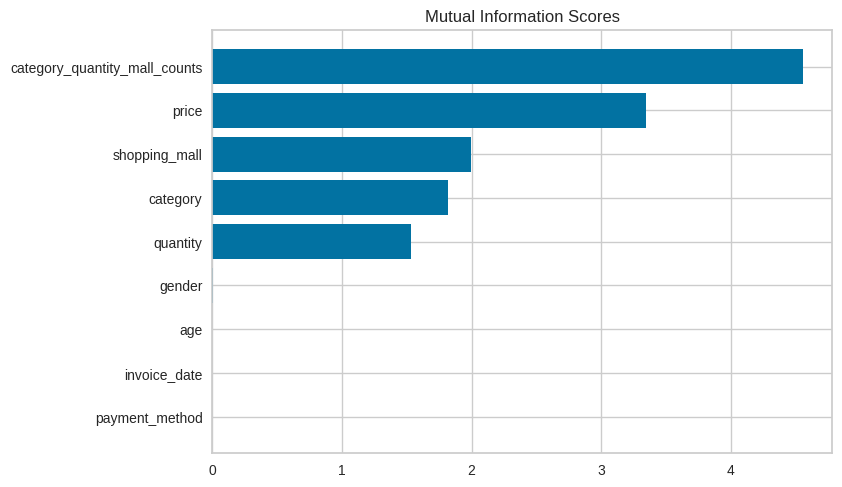

In [25]:
plot_mi_scores(mi_scores)

## 3 Feature Engineering

## 3.1 Create Features with Pandas

In [26]:
def extractions(df, feature_ord_levels):
    def split_by_age(age):
        if age <= 18:
            return 'Juvenile'
        if 19 <= age <= 44:
            return 'Youth'
        elif 45 <= age <= 59:
            return 'Average'
        elif 60 <= age:
            return 'Elderly'

    def get_season(invoice_date):
        season = invoice_date.dt.month % 12 // 3 + 1
        season = season.replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
        return season

    X = pd.DataFrame()
    X['age_group'] = df.apply(lambda row: split_by_age(row['age']), axis=1) \
        .astype(CategoricalDtype(feature_ord_levels['age_group'], ordered=True))
    X['season'] = get_season(df['invoice_date']).astype('category')
    
    return X

## 3.2 Create Final Dataset

In [27]:
def create_features(df, feature_target, mi_threshold, feature_outlier_thresholds, 
                    feature_new_ord_levels, feature_new_to_del, random_state=0):
    X = df.copy()
    
    mi_scores = make_mi_scores(X.drop(columns=feature_target), X[feature_target], 
                               random_state=random_state)
    #X = drop_uninformative(X, feature_target, mi_scores, mi_threshold)

    outlier_indexes = get_outlier_indexes(X, feature_outlier_thresholds)
    X = drop_outliers(X, outlier_indexes)
    
    #X = X.join(math_transforms(X, last_year))
    #X = X.join(counts(X))
    X = X.join(extractions(X, feature_new_ord_levels))
    #X = X.join(group_transforms(X))
    X = X.drop(columns=feature_new_to_del)
    
    return X

In [28]:
df_new = create_features(
    df, 
    MI_SCORES_FEATURE_TO_ESTIMATE,
    MI_SCORES_THRESHOLD,
    FEATURE_OUTLIER_THRESHOLDS,
    FEATURE_NEW_ORD_LEVELS,
    FEATURES_NEW_TO_DEL,
    random_state=RANDOM_STATE,
)

In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19483 entries, 0 to 19890
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   gender                         19483 non-null  category
 1   category                       19483 non-null  category
 2   quantity                       19483 non-null  category
 3   price                          19483 non-null  float64 
 4   payment_method                 19483 non-null  category
 5   shopping_mall                  19483 non-null  category
 6   category_quantity_mall_counts  19483 non-null  int64   
 7   category_quantity_mall_spent   19483 non-null  float64 
 8   age_group                      19483 non-null  category
 9   season                         19483 non-null  category
dtypes: category(7), float64(2), int64(1)
memory usage: 1.2 MB


## 3.3 MI Scores for New Features

In [30]:
X_new_mi = df_new.copy()
y_new_mi = X_new_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

new_mi_scores = make_mi_scores(X_new_mi, y_new_mi, random_state=RANDOM_STATE)
new_mi_scores

category_quantity_mall_counts    4.552317
price                            3.345940
shopping_mall                    1.998951
category                         1.819602
quantity                         1.536964
gender                           0.006361
season                           0.005166
payment_method                   0.000000
age_group                        0.000000
Name: MI Scores, dtype: float64

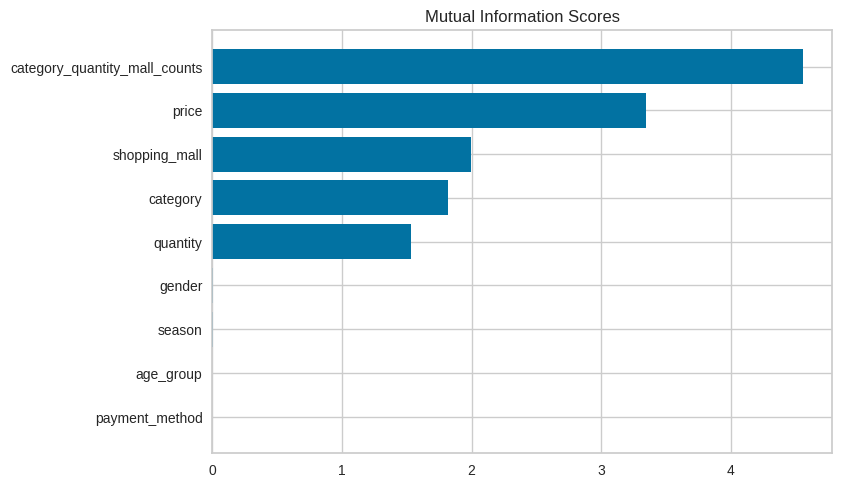

In [31]:
plot_mi_scores(new_mi_scores)

## 3.4 Feature Engineering Report

In [32]:
profiling_report = ProfileReport(df_new, title='Feature Engineering Profile Report')

In [33]:
profiling_report.to_file(REPORTS_DIR.joinpath('feature_engineering_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.5 Preprocessing Pipeline

In [34]:
def get_preprocessor(df, feature_ord_levels):
    features_num = list(df.select_dtypes(('int64', 'float64')).columns)
    features_ord = list(feature_ord_levels.keys())
    features_cat = [feature for feature in df.select_dtypes('category').columns \
                    if feature not in feature_ord_levels]

    assert len(features_num) + len(features_ord) + len(features_cat) == df.shape[1]
    
    num_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', QuantileTransformer()),
    ])

    cat_transformer = Pipeline([
        ('oh_encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
    ])
    
    ord_transformer = Pipeline([
        ('ord_encoder', OrdinalEncoder()),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_transformer, features_num),
        ('ord', ord_transformer, features_ord),
        ('cat', cat_transformer, features_cat),
    ])
    return preprocessor

In [35]:
preprocessor = get_preprocessor(df_new, FEATURE_NEW_ORD_LEVELS)

In [36]:
X = pd.DataFrame(preprocessor.fit_transform(df_new))
X.columns = preprocessor.get_feature_names_out()

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19483 entries, 0 to 19482
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__price                            19483 non-null  float64
 1   num__category_quantity_mall_counts    19483 non-null  float64
 2   num__category_quantity_mall_spent     19483 non-null  float64
 3   ord__quantity                         19483 non-null  float64
 4   ord__age_group                        19483 non-null  float64
 5   cat__gender_Male                      19483 non-null  float64
 6   cat__category_Clothing                19483 non-null  float64
 7   cat__category_Cosmetics               19483 non-null  float64
 8   cat__category_Food & Beverage         19483 non-null  float64
 9   cat__category_Shoes                   19483 non-null  float64
 10  cat__category_Souvenir                19483 non-null  float64
 11  cat__category_T

## 3.6 Dimensionality Reduction

### PCA

In [38]:
def apply_pca(X, n_components=None, standardize=True, random_state=0):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X)
    
    component_names = [f'PC{i + 1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )
    
    return pca, X_pca, loadings

In [39]:
def plot_variance(pca, width=8, dpi=100):
    fig, ax = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    evr = pca.explained_variance_ratio_
    ax[0].bar(grid, evr)
    ax[0].set(
        xlabel='Component',
        title='% Explained Variance',
        ylim=(0.0, 1.0),
    )
    
    cv = np.cumsum(evr)
    ax[1].plot(np.r_[0, grid], np.r_[0, cv], 'o-')
    ax[1].set(
        xlabel='Component',
        title='% Cumulative Variance',
        ylim=(0.0, 1.0),
    )
    
    fig.set(figwidth=width, dpi=dpi)
    plt.show()
    return ax

In [40]:
pca, _, _ = apply_pca(X, standardize=False, random_state=RANDOM_STATE)

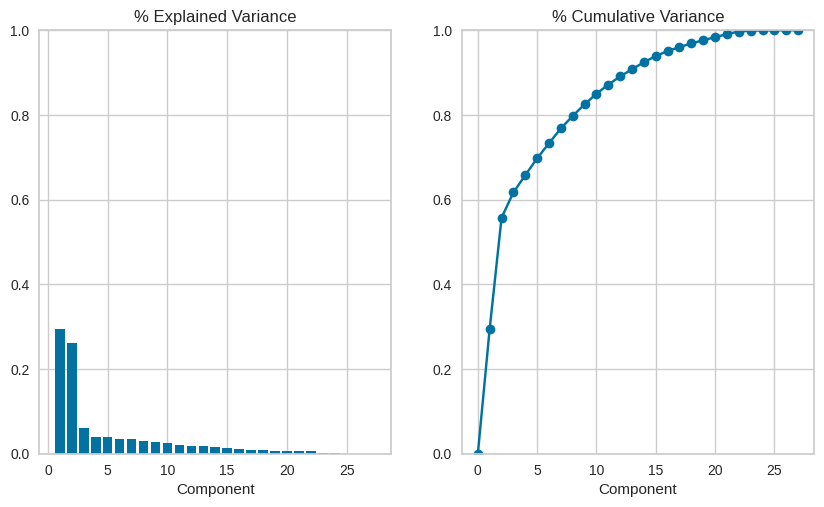

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

In [41]:
plot_variance(pca, width=10)

In [42]:
_, X_reduced, loadings = apply_pca(X, n_components=PCA_N_COMPONENTS)

In [43]:
loadings.sort_values(by='PC1', key=abs, ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
num__category_quantity_mall_spent,-0.531897,0.066363,-0.000295,-0.012167,-0.001509,0.006079,0.035549,0.011342,-0.003935,0.013124,0.011195,0.003195,0.016722,-0.009320,0.000356,-0.009240,0.003505,-0.004834,-0.008258,0.034629
num__price,-0.462732,0.365304,0.008148,-0.006913,-0.009026,0.002724,0.042819,-0.013097,0.025819,0.024784,-0.015492,0.009489,-0.004929,-0.021352,0.001210,-0.011015,-0.000961,-0.007097,-0.015776,0.074841
cat__category_Clothing,-0.425518,-0.164168,0.027850,-0.007170,0.005579,-0.118041,-0.415567,-0.078505,-0.101570,-0.160556,-0.066051,-0.121159,-0.079935,-0.005522,0.014312,0.008708,-0.003861,-0.003893,0.021875,-0.099183
num__category_quantity_mall_counts,-0.377862,-0.500529,-0.013613,-0.013175,0.006495,0.021441,0.040358,0.023847,0.013216,0.030367,-0.006467,0.030729,0.038362,0.003019,-0.001267,0.003739,0.009390,0.008121,0.012692,-0.051176
cat__category_Food & Beverage,0.273598,-0.324984,0.012778,-0.025563,-0.037665,-0.023412,-0.138725,-0.262265,0.149944,0.453695,-0.209356,0.108602,-0.047591,-0.173545,0.057631,0.016145,0.062532,-0.029509,0.031045,0.201732
cat__category_Souvenir,0.171852,0.057706,0.005677,0.014856,0.004629,0.019621,-0.071441,-0.059277,0.025445,-0.162107,0.097471,-0.336063,-0.118549,0.684097,-0.102877,-0.047385,-0.381324,-0.009271,-0.042500,0.083770
cat__category_Toys,0.127654,0.069701,-0.013735,-0.017561,0.030060,0.003459,0.045702,-0.125578,-0.252126,-0.195046,0.699032,0.135351,0.354770,-0.177344,-0.007098,-0.001930,0.157223,-0.056535,-0.008041,-0.056713
ord__quantity,-0.114982,0.095905,-0.031063,-0.060379,-0.026466,0.017140,0.147188,-0.038583,-0.464518,0.358131,0.090501,-0.161111,-0.068108,0.038441,0.008754,-0.049997,0.025883,-0.141201,-0.081707,0.675806
cat__category_Cosmetics,0.095219,-0.058024,-0.052100,0.022343,0.016678,0.081766,0.434699,0.621369,-0.225129,-0.209191,-0.287035,-0.029671,-0.114656,-0.098347,0.004093,-0.000423,0.103577,0.041156,-0.026500,-0.002655
cat__category_Shoes,-0.086412,0.431757,0.004104,0.000840,-0.021391,0.085568,0.320799,-0.135378,0.150043,0.482692,-0.032083,0.094158,-0.013085,0.080546,-0.063477,0.015367,-0.060938,0.100375,0.032349,-0.384821


## 4 Clustering

## 4.1 Hopkins Statistics

In [44]:
def get_hopkins_score(df, n_neighbours=2, hopkins_b=2):
    def hopkins(df, n_neighbours=n_neighbours):
        d = df.shape[1]
        n = len(df)
        m = int(0.1 * n) 
        nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(df.values)
     
        rand_df = random.sample(range(0, n, 1), m)
     
        ujd = []
        wjd = []
        for j in tqdm(range(0, m)):
            u_dist, _ = nbrs.kneighbors(
                np.random.uniform(np.amin(df, axis=0), np.amax(df, axis=0),d).reshape(1, -1), 2, return_distance=True)
            ujd.append(u_dist[0][1])
            w_dist, _ = nbrs.kneighbors(df.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
            wjd.append(w_dist[0][1])
     
        H = sum(ujd) / (sum(ujd) + sum(wjd))
        if math.isnan(H):
            print(ujd, wjd)
            H = 0
        return H
    
    return np.array([hopkins(df, n_neighbours) for _ in range(hopkins_b)]).mean() 

In [45]:
print(f'Hopkins Score: {get_hopkins_score(X_reduced)}')

100%|███████████████████████████████████████| 1948/1948 [00:19<00:00, 99.13it/s]

Hopkins Score: 0.9468927209883684


## 4.2 KMeans and Number of Clusters

### Distortion Score

In [46]:
def plot_distortion_elbow(df, k=(1, 10), random_state=0):
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(kmeans, k=k, metric='distortion').fit(df)
    visualizer.show()

    print(f'Optimal clusters number: {visualizer.elbow_value_}')

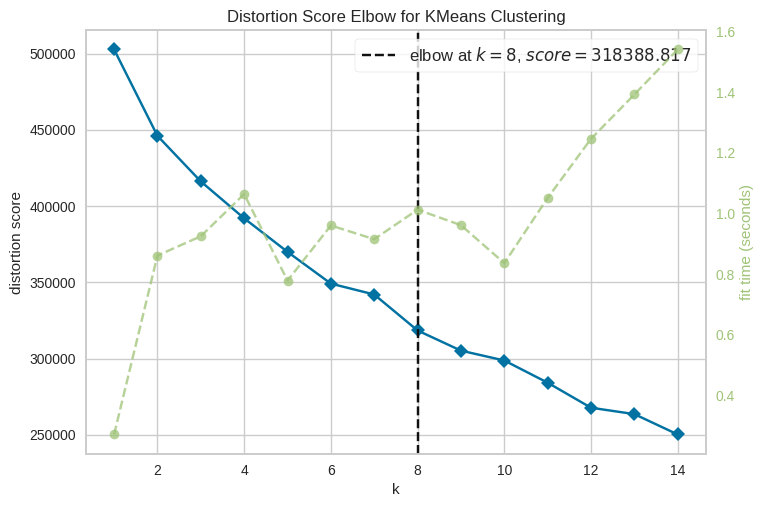

Optimal clusters number: 8


In [47]:
plot_distortion_elbow(X_reduced, k=(1, 15), random_state=RANDOM_STATE)

### Silhouette Method

In [48]:
def plot_silhouette_elbow(df, k=(2, 10), random_state=0):
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(kmeans, k=k, metric='silhouette').fit(df)
    visualizer.show()

    print(f'Optimal clusters number: {visualizer.elbow_value_}')

In [49]:
def plot_silhouette_visualization(df, k=2):
    kmeans = KMeans(k, random_state=RANDOM_STATE)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(df)        
    visualizer.show()

    print(f'Average silhouette score: {visualizer.silhouette_score_}')

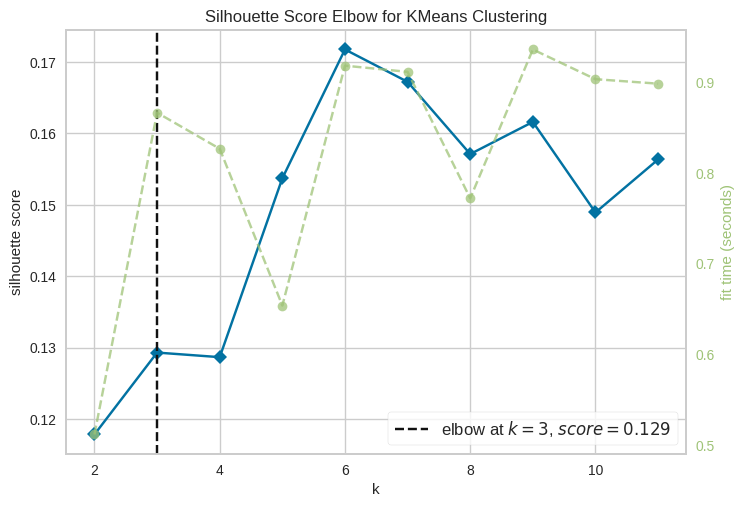

Optimal clusters number: 3


In [50]:
plot_silhouette_elbow(X_reduced, k=(2, 12), random_state=RANDOM_STATE)

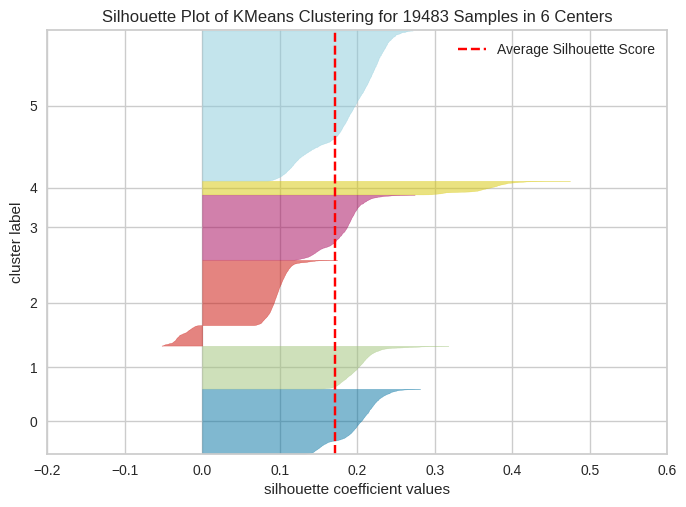

Average silhouette score: 0.17176230726892272


In [92]:
plot_silhouette_visualization(X_reduced, 6)

## 4.3 Agglomerative Clustering

In [93]:
def plot_cut_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
        
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendrogram')
        plt.xlabel('Number of elements (or cluster size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate(f'{y:.3g}', (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

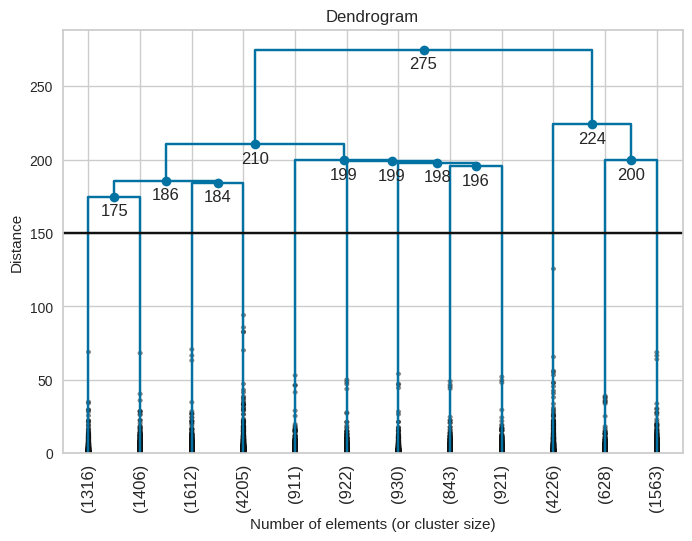

In [94]:
plot_cut_dendrogram(
    linkage(X_reduced, method='ward'),
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=150,
)
plt.show()

In [95]:
agglomerative = AgglomerativeClustering(n_clusters=N_CLUSTERS)
agglomerative.fit(X_reduced)
agglomerative_labels = list(agglomerative.labels_)

## 4.4 Evaluation

In [96]:
def prop_transforms(df):
    delta = 0.0001
    
    X = pd.DataFrame()
    X['prop_counts'] = df['category_quantity_mall_counts'] / (df['category_quantity_mall_counts'].sum() + delta) * 100
    X['prop_spent'] = df['category_quantity_mall_spent'] / (df['category_quantity_mall_spent'].sum() + delta) * 100
    return X

In [97]:
def describe_features_num(df, cluster, features_num_interesting):
    return df.loc[df['cluster'] == cluster, features_num_interesting].describe().T

In [98]:
def describe_features_cat(df, cluster, features_cat_interesting):
    for feature in features_cat_interesting:
        print(df.loc[df['cluster'] == cluster, feature].value_counts(normalize=True))
        print()

In [99]:
df_new_props = df_new.join(prop_transforms(df_new))
df_new_props['cluster'] = agglomerative_labels

### Group 1

In [108]:
describe_features_num(df_new_props, 0, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,3616.0,442.533197,652.031652,5.230000,30.300000,81.320000,600.170000,3000.850000
prop_counts,3616.0,0.001839,0.001013,0.000239,0.001050,0.001527,0.002863,0.004008
prop_spent,3616.0,0.001464,0.002135,0.000006,0.000046,0.000170,0.002395,0.007330


In [109]:
describe_features_cat(df_new_props, 0, FEATURES_CAT_INTERESTING)

category
Clothing           0.280973
Souvenir           0.261062
Food & Beverage    0.128872
Cosmetics          0.119469
Toys               0.086007
Shoes              0.084624
Books              0.038993
Technology         0.000000
Name: proportion, dtype: float64

quantity
1    0.202157
4    0.201604
3    0.199945
2    0.199115
5    0.197179
Name: proportion, dtype: float64

shopping_mall
Forum Istanbul       0.268805
Zorlu Center         0.257190
Viaport Outlet       0.254978
Mall of Istanbul     0.058905
Kanyon               0.053374
Metrocity            0.040100
Istinye Park         0.029591
Metropol AVM         0.023783
Cevahir AVM          0.013274
Emaar Square Mall    0.000000
Name: proportion, dtype: float64

age_group
Youth       0.498617
Average     0.288993
Elderly     0.190265
Juvenile    0.022124
Name: proportion, dtype: float64

season
Winter    0.308628
Spring    0.239768
Summer    0.235896
Fall      0.215708
Name: proportion, dtype: float64



### Group 2

In [110]:
describe_features_num(df_new_props, 1, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,8539.0,208.057383,354.465997,5.230000,26.150000,81.320000,179.200000,1500.400000
prop_counts,8539.0,0.004284,0.001828,0.000191,0.002815,0.004198,0.005868,0.007490
prop_spent,8539.0,0.001729,0.003501,0.000008,0.000125,0.000316,0.001083,0.015796


In [111]:
describe_features_cat(df_new_props, 1, FEATURES_CAT_INTERESTING)

category
Cosmetics          0.284577
Food & Beverage    0.279775
Toys               0.188781
Clothing           0.157630
Books              0.089238
Shoes              0.000000
Souvenir           0.000000
Technology         0.000000
Name: proportion, dtype: float64

quantity
3    0.204825
5    0.204239
2    0.198033
1    0.196510
4    0.196393
Name: proportion, dtype: float64

shopping_mall
Kanyon               0.213491
Mall of Istanbul     0.210798
Metropol AVM         0.190069
Istinye Park         0.176719
Metrocity            0.153999
Cevahir AVM          0.054924
Emaar Square Mall    0.000000
Forum Istanbul       0.000000
Viaport Outlet       0.000000
Zorlu Center         0.000000
Name: proportion, dtype: float64

age_group
Youth       0.510598
Average     0.279307
Elderly     0.190303
Juvenile    0.019792
Name: proportion, dtype: float64

season
Winter    0.292891
Spring    0.240543
Summer    0.233751
Fall      0.232814
Name: proportion, dtype: float64



### Group 3

In [112]:
describe_features_num(df_new_props, 2, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,4226.0,893.778268,423.347418,300.080000,600.160000,900.240000,1200.320000,1500.400000
prop_counts,4226.0,0.011732,0.002884,0.002863,0.010639,0.012691,0.013454,0.015028
prop_spent,4226.0,0.015017,0.007983,0.001466,0.006442,0.013009,0.021557,0.029527


In [113]:
describe_features_cat(df_new_props, 2, FEATURES_CAT_INTERESTING)

category
Clothing           1.0
Books              0.0
Cosmetics          0.0
Food & Beverage    0.0
Shoes              0.0
Souvenir           0.0
Technology         0.0
Toys               0.0
Name: proportion, dtype: float64

quantity
2    0.211548
1    0.199716
4    0.199006
5    0.195220
3    0.194510
Name: proportion, dtype: float64

shopping_mall
Mall of Istanbul     0.331756
Kanyon               0.326550
Metrocity            0.257690
Cevahir AVM          0.084004
Emaar Square Mall    0.000000
Forum Istanbul       0.000000
Istinye Park         0.000000
Metropol AVM         0.000000
Viaport Outlet       0.000000
Zorlu Center         0.000000
Name: proportion, dtype: float64

age_group
Youth       0.510175
Average     0.291529
Elderly     0.183152
Juvenile    0.015144
Name: proportion, dtype: float64

season
Winter    0.298628
Spring    0.238760
Fall      0.235211
Summer    0.227402
Name: proportion, dtype: float64



### Group 4

In [114]:
describe_features_num(df_new_props, 3, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,1563.0,1813.181536,857.997138,600.170000,1200.340000,1800.510000,2400.680000,3000.850000
prop_counts,1563.0,0.002924,0.000978,0.000811,0.002195,0.002863,0.003674,0.004485
prop_spent,1563.0,0.007731,0.004858,0.000867,0.003717,0.006360,0.010159,0.019410


In [115]:
describe_features_cat(df_new_props, 3, FEATURES_CAT_INTERESTING)

category
Shoes              1.0
Books              0.0
Clothing           0.0
Cosmetics          0.0
Food & Beverage    0.0
Souvenir           0.0
Technology         0.0
Toys               0.0
Name: proportion, dtype: float64

quantity
5    0.210493
1    0.202175
4    0.198337
3    0.195138
2    0.193858
Name: proportion, dtype: float64

shopping_mall
Mall of Istanbul     0.255918
Kanyon               0.233525
Metrocity            0.181702
Metropol AVM         0.133717
Istinye Park         0.131158
Cevahir AVM          0.063980
Emaar Square Mall    0.000000
Forum Istanbul       0.000000
Viaport Outlet       0.000000
Zorlu Center         0.000000
Name: proportion, dtype: float64

age_group
Youth       0.500320
Average     0.301983
Elderly     0.183621
Juvenile    0.014075
Name: proportion, dtype: float64

season
Winter    0.290467
Spring    0.247601
Summer    0.234165
Fall      0.227767
Name: proportion, dtype: float64



### Group 5

In [116]:
describe_features_num(df_new_props, 4, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,628.0,2108.359873,850.071402,1050.000000,1050.000000,2100.000000,3150.000000,3150.000000
prop_counts,628.0,0.001377,0.000632,0.000286,0.000906,0.001622,0.001861,0.002290
prop_spent,628.0,0.004253,0.002762,0.000650,0.002023,0.002890,0.006503,0.010187


In [117]:
describe_features_cat(df_new_props, 4, FEATURES_CAT_INTERESTING)

category
Technology         1.0
Books              0.0
Clothing           0.0
Cosmetics          0.0
Food & Beverage    0.0
Shoes              0.0
Souvenir           0.0
Toys               0.0
Name: proportion, dtype: float64

quantity
2    0.345541
3    0.331210
1    0.323248
4    0.000000
5    0.000000
Name: proportion, dtype: float64

shopping_mall
Mall of Istanbul     0.213376
Kanyon               0.179936
Metrocity            0.159236
Istinye Park         0.106688
Metropol AVM         0.100318
Zorlu Center         0.054140
Cevahir AVM          0.049363
Forum Istanbul       0.047771
Viaport Outlet       0.046178
Emaar Square Mall    0.042994
Name: proportion, dtype: float64

age_group
Youth       0.487261
Average     0.300955
Elderly     0.202229
Juvenile    0.009554
Name: proportion, dtype: float64

season
Winter    0.291401
Spring    0.242038
Fall      0.235669
Summer    0.230892
Name: proportion, dtype: float64



### Group 6

In [120]:
describe_features_num(df_new_props, 5, FEATURES_NUM_INTERESTING)

,count,mean,std,min,25%,50%,75%,max
price,911.0,572.332711,685.814204,5.230000,46.920000,203.300000,900.240000,3000.850000
prop_counts,911.0,0.001929,0.001132,0.000239,0.001097,0.001384,0.003244,0.003769
prop_spent,911.0,0.001894,0.002212,0.000008,0.000057,0.000448,0.003510,0.007124


In [121]:
describe_features_cat(df_new_props, 5, FEATURES_CAT_INTERESTING)

category
Clothing           0.377607
Cosmetics          0.155873
Food & Beverage    0.144896
Shoes              0.117453
Toys               0.109769
Books              0.047201
Souvenir           0.047201
Technology         0.000000
Name: proportion, dtype: float64

quantity
3    0.205269
2    0.201976
1    0.200878
5    0.200878
4    0.190999
Name: proportion, dtype: float64

shopping_mall
Emaar Square Mall    1.0
Cevahir AVM          0.0
Forum Istanbul       0.0
Istinye Park         0.0
Kanyon               0.0
Mall of Istanbul     0.0
Metrocity            0.0
Metropol AVM         0.0
Viaport Outlet       0.0
Zorlu Center         0.0
Name: proportion, dtype: float64

age_group
Youth       0.511526
Average     0.277717
Elderly     0.190999
Juvenile    0.019759
Name: proportion, dtype: float64

season
Winter    0.298573
Spring    0.240395
Summer    0.231614
Fall      0.229418
Name: proportion, dtype: float64

